# Модулятор Double Sideband Transmitted Carrier (AM-DSB-TC)

## 4. Модуляция звуковым сигналом
Рассмотрим, как будет выглядеть спектр сигнала после модуляции, если
информационное сообщение является аудиосигналом. В файле
Audio\_Source.wav записано звуковое сообщение с частотой дискретизации
44.1 kHz. Частота несущей будет равна 60 kHz. Чтобы избежать наложения
спектров, выберем итоговую частоту дискретизации модулированного сигнала
в 5 раз больше частоты аудиосигнала, то есть 5 \* 44.1 kHz. Это
потребует провести интерполяцию для увеличения частоты дискретизации
информационного сообщения.


<IPython.core.display.Javascript object>


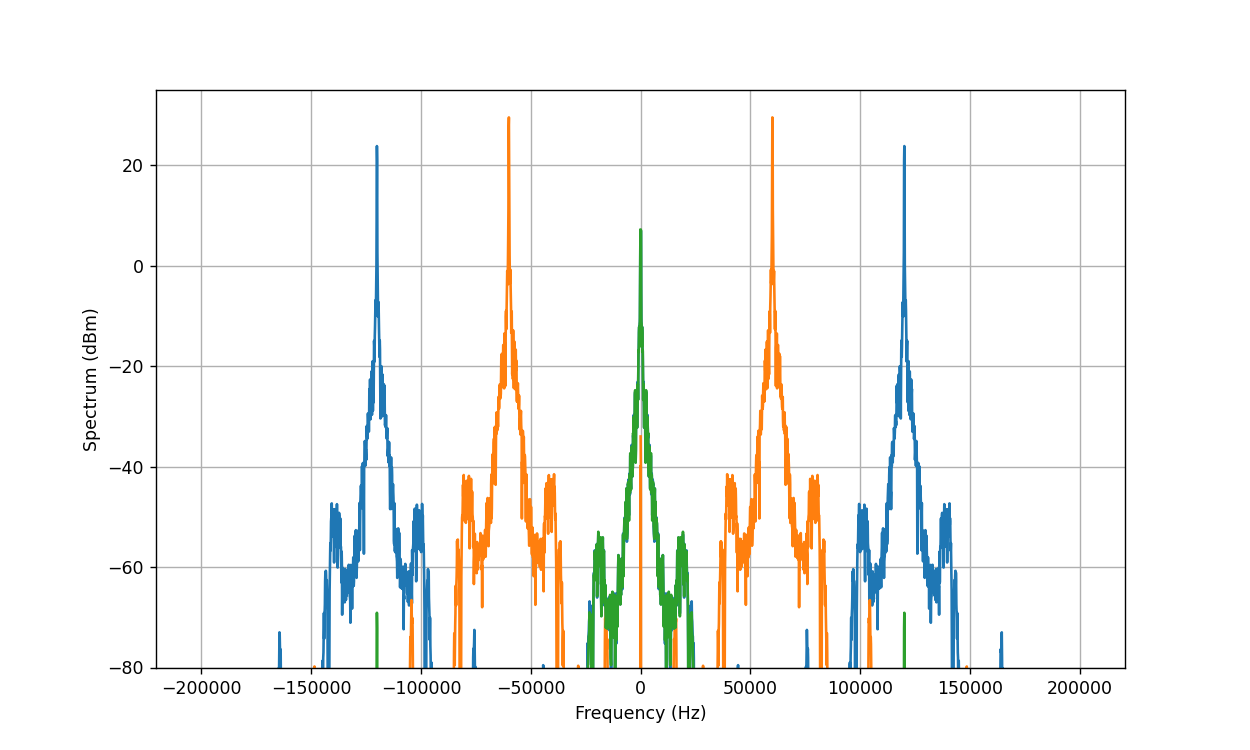

In [83]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly, firls, lfilter

audio_frame_size = 1000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500      # число обрабатываемых пачек данных
rate_ratio = 10          # коэффициент увеличения частоты дискретизации
audio_amp = 0.1          # коэффициент усиления аудиосигнала
Fc = 60e3                # частота несущей
Ac = 2                   # амплитуда несущей

freq_offset = 10               # расстройка по частоте (Hz)
phase_offset = 0 * np.pi/180  # расстройка по фазе (градусы)

# открываем файл и получаем частоту дискретизации
audio_file = wave.open('../../wav/Audio_Source.wav')
audio_fs = audio_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
signal_fs = audio_fs * rate_ratio
signal_frame_size = audio_frame_size * rate_ratio

# получение коэффициентов ФНЧ
H = firls(175, (0, 20e3, 30e3, signal_fs/2), (1, 1, 0, 0), fs=signal_fs)

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-80, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

message = []
FIR_tap_values = np.zeros(len(H) - 1) # внутреннее состояние ФНЧ

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    am_signal = audio_file.readframes(audio_frame_size)      # считываем отсчеты
    am_signal = np.frombuffer(am_signal, dtype=np.int16)          # преобразуем тип данных из byte в int16
    am_signal = np.reshape(am_signal, (-1, 2))                    # разделяем отсчеты для правого и левого канала
    am_signal = am_signal[:,0] / 2**15                            # выделяем один канал и нормируем отсчеты к единице
    
    # МОДУЛЯЦИЯ
    # увеличиваем частоту дискретизации
    upsampled_data = resample_poly(am_signal, rate_ratio, 1)
    
    # несущий сигнал
    # частота несущей: 60 kHz
    carrier = np.cos(2 * np.pi * Fc * t)
    
    # амплитудная модуляция
    am_signal = (Ac + upsampled_data) * carrier
    
    
    # ДЕМОДУЛЯЦИЯ
    # формируем несущую с возможными ошибками
    demod_carrier = np.cos(2 * np.pi * (Fc + freq_offset) * t + phase_offset)
    
    # смешивание АМ-сигнала и несущей
    mixed_signal = am_signal * demod_carrier;
    
    # фильтрация сигнала
    baseband_signal, FIR_tap_values = lfilter(H, 1.0, np.real(mixed_signal), zi=FIR_tap_values)
    baseband_signal = baseband_signal - baseband_signal.mean()
    
    # построение спектрограмм
    signals = mixed_signal, am_signal, baseband_signal
    
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=4096) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # уменьшение частоты дискретизации
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)



Можно увидеть, что спектр информационного сообщения перенесен на частоту
несущей.

## 5. Преимущества и недостатки DSB-SC
Преимущества:
- простота модулятора;
- модуляция эффективна с точки зрения мощности, так как несущая не передается.

Недостатки:
- если информационное сообщение изменяет знак, то возможна только когерентная демодуляция;
- несущая не передается, ее нужно восстанавливать из сигнала, это усложняет демодулятор;
- полоса модулированного сигнала в 2 раза больше полосы информационного сообщения.

## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR